In [452]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

import sys

sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis/py_functions')

from scipy.stats import norm
from tkinter import *
import scipy
from scipy import signal

import platform
from glob import glob
from scipy.spatial import distance
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz

import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
import LL_funcs as LLf
import freq_funcs as ff
import h5py
import copy
#
from scipy.signal import hilbert, butter, filtfilt
import scipy.stats as stats
from tqdm.notebook import trange, tqdm
import matplotlib.cm as cm
from scipy.stats import pearsonr, ttest_rel

In [453]:
dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'BrainMapping'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()
sub_path  ='X:\\4 e-Lab\\' # y:\\eLab

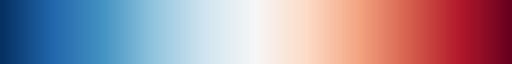

In [524]:
import matplotlib
cmap = matplotlib.colormaps["RdBu_r"]
cmap.set_bad(color='grey')
cmap

In [517]:
subj = 'EL022'
cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'

if cond_folder == 'Ph':
    cond_vals = np.arange(4)
    cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
    cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]
    cond1 = 'Condition'  # 'condition', 'h'
    cond_folder = 'Ph'  # 'Ph', 'Sleep', 'CR'
    Condition = 'Condition'
if cond_folder == 'CR':
    Condition = 'Hour'  # Condition = 'Hour'
    cond1 = 'h'  # h (as stored in stimlist)

######## General Infos

path_patient_analysis = sub_path+'\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
path_gen = os.path.join(sub_path+'\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_gen, 'Electrodes')
if not os.path.exists(os.path.join(path_infos, subj + "_labels.xlsx")):
    path_infos = os.path.join(path_gen, 'infos')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'

sep = ';'
Fs = 500
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/BM_plot_trial').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/single_con').mkdir(parents=True,
                                                                                              exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/Pipeline').mkdir(parents=True, exist_ok=True)

# get labels
if cond_folder == 'Ph':
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*Ph*')
else:
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
i = 0
stimlist = pd.read_csv(files_list[i])

lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
if "type"in lbls:
    lbls = lbls[lbls.type=='SEEG']
    lbls = lbls.reset_index(drop=True)
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)

labels_h = lbls.Hemisphere + '_' + labels_all

badchans = pd.read_csv(path_patient_analysis + '\\' + folder + '/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:, 1] == 1))[0, :])

bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

file_con_all = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'

con_trial = pd.read_csv(file_con)


In [518]:
con_trial.insert(5, 'CT', 'BL')
if subj =='EL022':
    con_trial.loc[(con_trial.Block==18), 'CT'] ='S_V'
    con_trial.loc[(con_trial.Block==19), 'CT'] ='S_A'
    con_trial.loc[(con_trial.Block==20), 'CT'] ='C_V'
    con_trial.loc[(con_trial.Block==21), 'CT'] ='C_A'
    
if subj =='EL025':
    con_trial.loc[(con_trial.Block==32), 'CT'] ='S_V'
    con_trial.loc[(con_trial.Block==33), 'CT'] ='S_A'
    con_trial.loc[(con_trial.Block==34), 'CT'] ='C_V'
    con_trial.loc[(con_trial.Block==35), 'CT'] ='C_A'
    
if subj =='EL024':
    con_trial.loc[(con_trial.Block==36), 'CT'] ='S_V'
    con_trial.loc[(con_trial.Block==37), 'CT'] ='S_A'

In [519]:
h5_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.h5'
if os.path.isfile(h5_file):
    print('loading h5')
    EEG_resp = h5py.File(h5_file)
    EEG_resp = EEG_resp['EEG_resp']

loading h5


In [520]:
con_trial.Num = con_trial.Num.astype('int')
con_trial.Stim = con_trial.Stim.astype('int')
con_trial.Chan = con_trial.Chan.astype('int')
con_trial.Artefact = con_trial.Artefact.astype('int')
con_trial.Num_block = con_trial.Num_block.astype('int')
con_trial.Date = con_trial.Date.astype('int')
con_trial.Block = con_trial.Block.astype('int')
con_trial.Sleep = con_trial.Sleep.astype('int')
con_trial.Hour = con_trial.Hour.astype('int')

In [521]:
Fs             = 500
dur            = np.zeros((1,2), dtype=np.int32)
t0 = 1
dur[0,0] =  -t0
dur[0,1] =  3

#dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax           = np.arange(dur[0,0],dur[0,1],(1/Fs))
color_elab = np.zeros((3,3))
color_elab[0,:] = np.array([31, 78, 121])/255
color_elab[1,:] = np.array([189, 215, 238])/255
color_elab[2,:] = np.array([0.256, 0.574, 0.431])

### Brain MAp for 5 conditions

In [522]:
con_trial_CT = con_trial[(con_trial.Artefact<1) &(con_trial.Sig >-1) &(con_trial.Sleep ==0) &((con_trial.Hour>10) | (con_trial.Hour<20))]
con_trial_CT = con_trial_CT.reset_index(drop=True)
con_trial_CT.insert(4, 'LL_sig', con_trial_CT.LL*con_trial_CT.Sig)

In [523]:
con_mean_CT = con_trial_CT.groupby(['Stim', 'Chan', 'CT'], as_index=False)[['Sig', 'LL','LL_sig']].mean()
con_mean_CT['Con_ID'] = con_mean_CT.groupby(['Stim', 'Chan']).ngroup()
con_trial_CT = con_trial_CT.reset_index(drop=True)

In [525]:
hemisphere = [h[0] for h in labels_h]

In [526]:
# Create a Series of LL_BL values based on CT == 'BL' for each connection (groupby)
ll_bl_series = con_mean_CT[con_mean_CT['CT'] == 'BL'].groupby('Con_ID')['LL_sig'].first()

# Calculate LL_norm using LL_BL values
con_mean_CT['LL_norm'] = con_mean_CT['LL'] / con_mean_CT['Con_ID'].map(ll_bl_series)

In [721]:
cluster_method  = 'similarity'
file_CC_summ = path_patient_analysis + '\\' + folder + '\\data\\CC_summ_'+cluster_method+'.csv'
CC_summ = pd.read_csv(file_CC_summ)
CC_summ = CC_summ[(CC_summ.sig==1)]
CC_summ = CC_summ.reset_index(drop=True)
CC_summ = CC_summ.groupby(['Stim', 'Chan'], as_index=False)[['t_WOI', 'd']].mean()
CC_summ = CC_summ.reset_index(drop=True)
CC_summ.Stim = CC_summ.Stim.astype('int')
CC_summ.Chan = CC_summ.Chan.astype('int')

In [606]:
k = -1


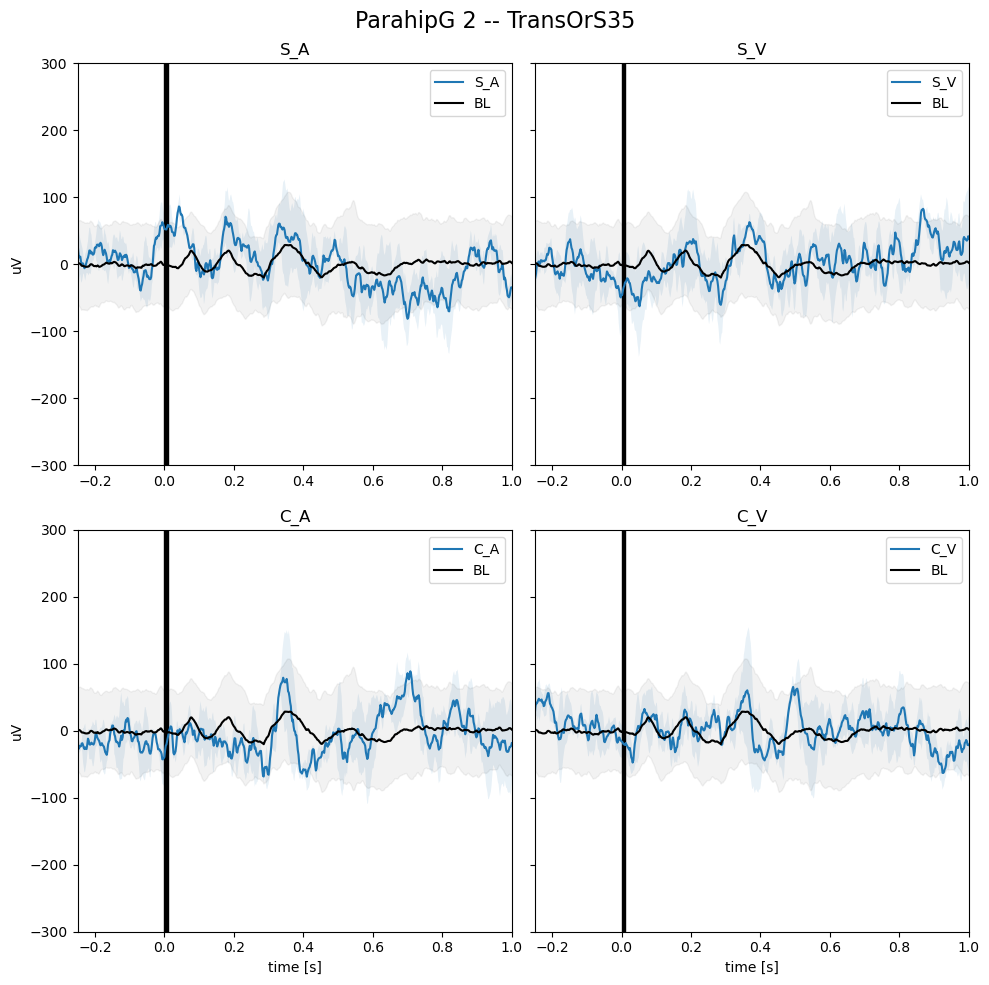

In [607]:
plot_conditions(con_trial_CT, EEG_resp, sc, rc,labels_all)
plt.ylim([-300,300])
plt.show()

### Pearson

In [818]:
def compute_pairwise_correlations(data, t, win = 0.25, t0 = 1, Fs=500):
    t_start = int((t0+t)*Fs)
    t_end = int(t_start+win*Fs)
    n_trials = data.shape[0]
    correlations = np.ones((n_trials, n_trials))
    for i in range(n_trials):
        for j in range(i+1, n_trials):
            correlations[i, j], _ = pearsonr(data[i, t_start:t_end], data[j, t_start:t_end])
            correlations[j, i] = correlations[i, j]
    return correlations


In [835]:
import itertools
results = []

for idx in range(len(CC_summ)):
    stimulus = CC_summ.Stim.values[idx]
    response_channel = CC_summ.Chan.values[idx]
    
    # Filter data based on conditions and stimulus-response channels
    filtered_data = con_trial_CT[(con_trial_CT.CT.isin(conditions)) &
                                 (con_trial_CT.Stim == stimulus) &
                                 (con_trial_CT.Chan == response_channel)]
    filtered_data.reset_index(drop=True, inplace=True)
    
    num = filtered_data.Num.values
    CT_labels = filtered_data.CT.values
    
    # Fetch the window of interest (WOI)
    WOI = CC_summ.loc[(CC_summ.Stim == stimulus) & (CC_summ.Chan == response_channel), "t_WOI"].values
    WOI = WOI[0] if len(WOI) > 0 else 0
    
    # Compute the correlations
    correlations = compute_pairwise_correlations(EEG_resp[response_channel, num, :], WOI, win=0.25, t0=1, Fs=500)
    np.fill_diagonal(correlations, np.nan)
    
    # Calculate mean correlation for unique condition pairs
    for CT1, CT2 in itertools.combinations(conditions, 2):
        indices1 = [i for i, label in enumerate(CT_labels) if label == CT1]
        indices2 = [i for i, label in enumerate(CT_labels) if label == CT2]
        mean_corr = np.mean(correlations[indices1, :][:, indices2])
        results.append({"Stim": stimulus, "Chan": response_channel, "CT1": CT1, "CT2": CT2, "S": mean_corr})
    
    # Add condition with itself
    for CT in conditions:
        indices = [i for i, label in enumerate(CT_labels) if label == CT]
        mean_corr = np.nanmean(correlations[indices, :][:, indices])
        results.append({"Stim": stimulus, "Chan": response_channel, "CT1": CT, "CT2": CT, "S": mean_corr})
        
    # adding a BL condition to compare with
    
    # Filter data based on conditions and stimulus-response channels
    filtered_data = con_trial_CT[(con_trial_CT.CT=="BL") &
                                 (con_trial_CT.Stim == stimulus) &
                                 (con_trial_CT.Chan == response_channel)]
    filtered_data.reset_index(drop=True, inplace=True)
    
    num = np.sort(filtered_data.Num.values[np.random.choice(len(filtered_data), 12,replace = False)])
    CT_labels = filtered_data.CT.values
    
    # Compute the correlations
    correlations = compute_pairwise_correlations(EEG_resp[response_channel, num, :], WOI, win=0.25, t0=1, Fs=500)
    np.fill_diagonal(correlations, np.nan)
    indices = [i for i, label in enumerate(CT_labels) if label == CT]
    mean_corr = np.nanmean(correlations)
    results.append({"Stim": stimulus, "Chan": response_channel, "CT1": "BL", "CT2": "BL", "S": mean_corr})

# Convert results to DataFrame 
df_results = pd.DataFrame(results)

In [836]:
df_results = pd.DataFrame(results)
df_results['Comp'] = df_results['CT1']+'-'+df_results['CT2']
df_results = df_results.merge(CC_summ, on = ['Stim', 'Chan'])
df_results = df_results.merge(con_trial[con_trial.Sig>-1].groupby(['Stim', 'Chan'], as_index=False)['Sig'].mean(), on = ['Stim', 'Chan'])
#df_results['Comp'] = df_results.groupby(['CT1', 'CT2']).ngroup()

In [838]:
df_results

,Stim,Chan,CT1,CT2,S,Comp,t_WOI,d,Sig
0,0,2,S_A,S_V,0.401390,S_A-S_V,0.0,7.0,0.953416
1,0,2,S_A,C_A,0.448664,S_A-C_A,0.0,7.0,0.953416
2,0,2,S_A,C_V,0.722251,S_A-C_V,0.0,7.0,0.953416
3,0,2,S_V,C_A,0.264295,S_V-C_A,0.0,7.0,0.953416
4,0,2,S_V,C_V,0.508225,S_V-C_V,0.0,7.0,0.953416
...,...,...,...,...,...,...,...,...,...
43489,95,93,S_A,S_A,0.642622,S_A-S_A,0.0,7.0,0.956113
43490,95,93,S_V,S_V,0.348062,S_V-S_V,0.0,7.0,0.956113
43491,95,93,C_A,C_A,0.257539,C_A-C_A,0.0,7.0,0.956113
43492,95,93,C_V,C_V,0.404460,C_V-C_V,0.0,7.0,0.956113


C:\Users\i0328442\AppData\Local\Temp\ipykernel_17976\2252276674.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_map = df_results[(df_results.Stim == sc)&(df_results.Chan == rc)].pivot("CT1", "CT2", "S")


<Axes: xlabel='CT2', ylabel='CT1'>

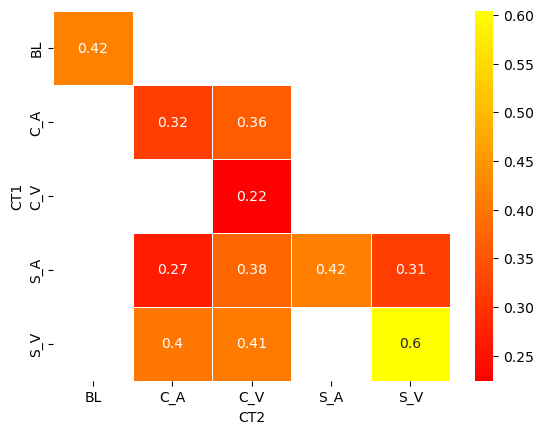

In [837]:
sc = 0
rc = 14
df_map = df_results[(df_results.Stim == sc)&(df_results.Chan == rc)].pivot("CT1", "CT2", "S")
sns.heatmap(df_map, annot=True, cmap='autumn', linewidth=.5)

<Axes: xlabel='CT2', ylabel='CT1'>

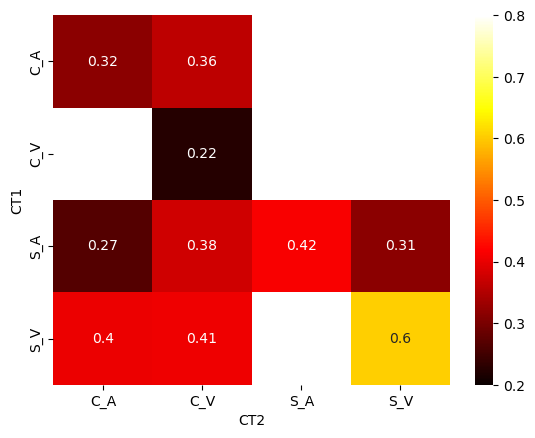

<Axes: xlabel='d', ylabel='Sig'>

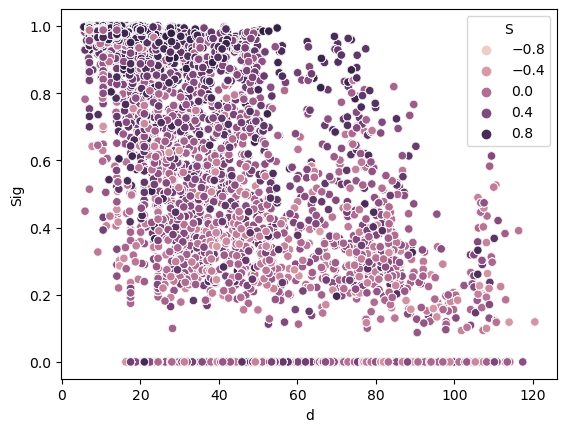

In [817]:
sns.scatterplot(x = 'd', y = 'Sig', hue = 'S', data = df_results)

(0.3, 0.5)

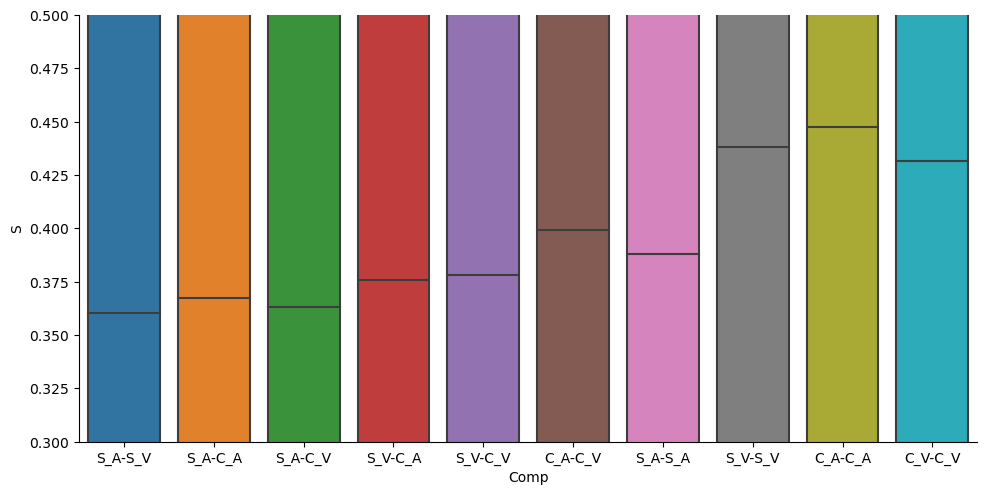

In [780]:
sns.catplot(x='Comp', y='S', data= df_results[(df_results.Sig>0.2)], kind = 'box', aspect = 2)
plt.ylim([0.3, 0.5])

In [677]:
df_results

,Stim,Chan,CT1,CT2,S,Comp
0,0,2,S_A,S_V,0.401390,S_A-S_V
1,0,2,S_A,C_A,0.448664,S_A-C_A
2,0,2,S_A,C_V,0.722251,S_A-C_V
3,0,2,S_V,C_A,0.264295,S_V-C_A
4,0,2,S_V,C_V,0.508225,S_V-C_V
...,...,...,...,...,...,...
23719,95,93,S_A,C_A,0.461501,S_A-C_A
23720,95,93,S_A,C_V,0.498285,S_A-C_V
23721,95,93,S_V,C_A,0.359348,S_V-C_A
23722,95,93,S_V,C_V,0.541259,S_V-C_V


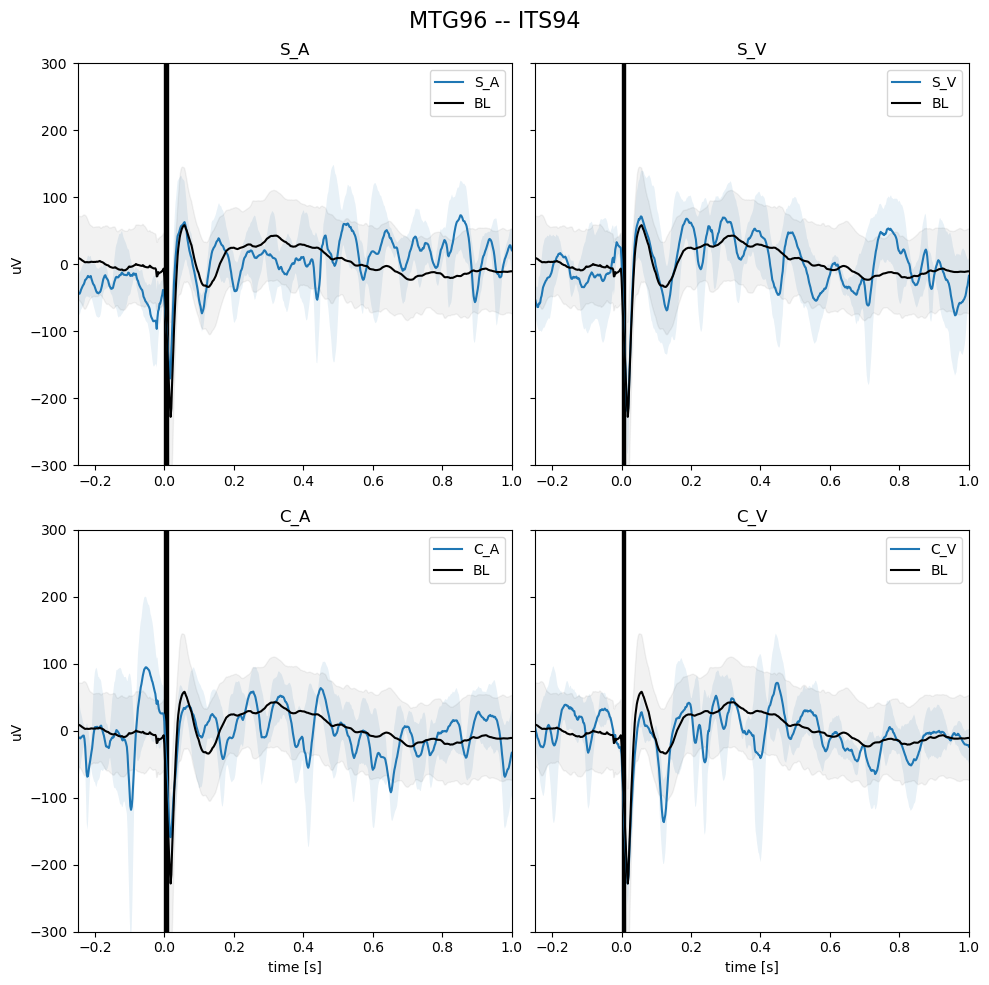

In [679]:
plot_conditions(con_trial_CT, EEG_resp, 95, 93,labels_all)
plt.ylim([-300,300])
plt.show()

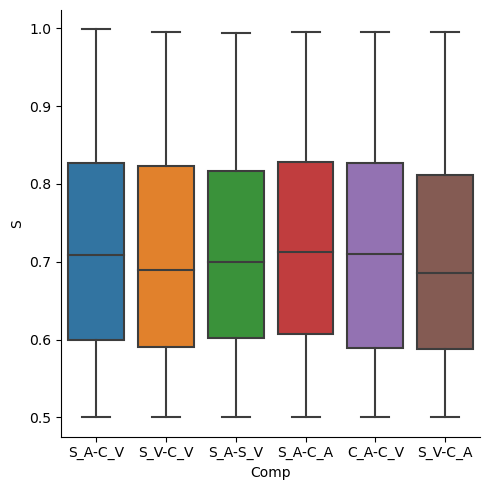

In [676]:
sns.catplot(x='Comp', y='S', data= df_results[df_results.S>0.5], kind = 'box')


In [659]:
df_results = pd.DataFrame(results)
df_results

,Stim,Chan,CT1,CT2,S
0,0,7,S_A,S_A,0.422242
1,0,7,S_A,S_V,0.191593
2,0,7,S_A,C_A,0.498047
3,0,7,S_A,C_V,0.250146
4,0,7,S_V,S_A,0.191593
5,0,7,S_V,S_V,0.535114
6,0,7,S_V,C_A,0.155267
7,0,7,S_V,C_V,0.228885
8,0,7,C_A,S_A,0.498047
9,0,7,C_A,S_V,0.155267


In [639]:
data_sel.CT.values

array(['S_V', 'S_V', 'S_V', 'S_A', 'S_A', 'S_A', 'C_V', 'C_V', 'C_V',
       'C_A', 'C_A', 'C_A'], dtype=object)

In [636]:
corr.shape

(12, 12)

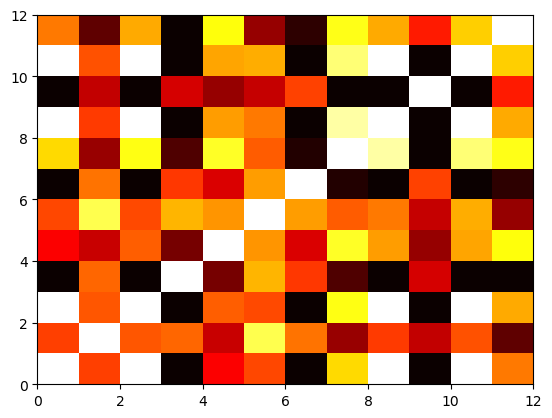

In [637]:
plt.pcolormesh(corr, cmap ='hot', vmin = 0, vmax = 0.9)

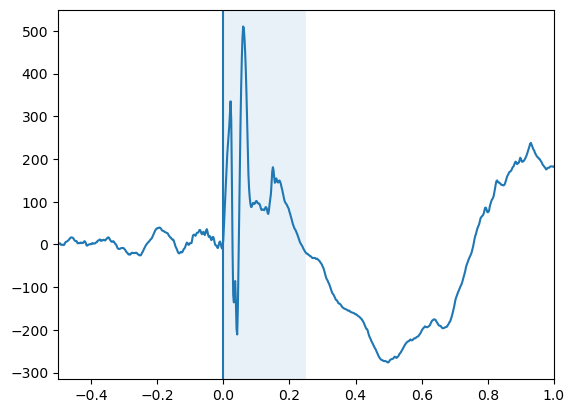

In [625]:
plt.plot(x_ax, np.mean(EEG_resp[rc, num, :],0))
plt.xlim([-0.5, 1])
plt.axvline(0)
plt.axvspan(WOI, WOI+0.25, alpha= 0.1)

In [ ]:
k = k+1
sc =CC_summ.Stim.values[k]
rc =CC_summ.Chan.values[k]
plot_conditions(con_trial_CT, EEG_resp, sc, rc,labels_all)

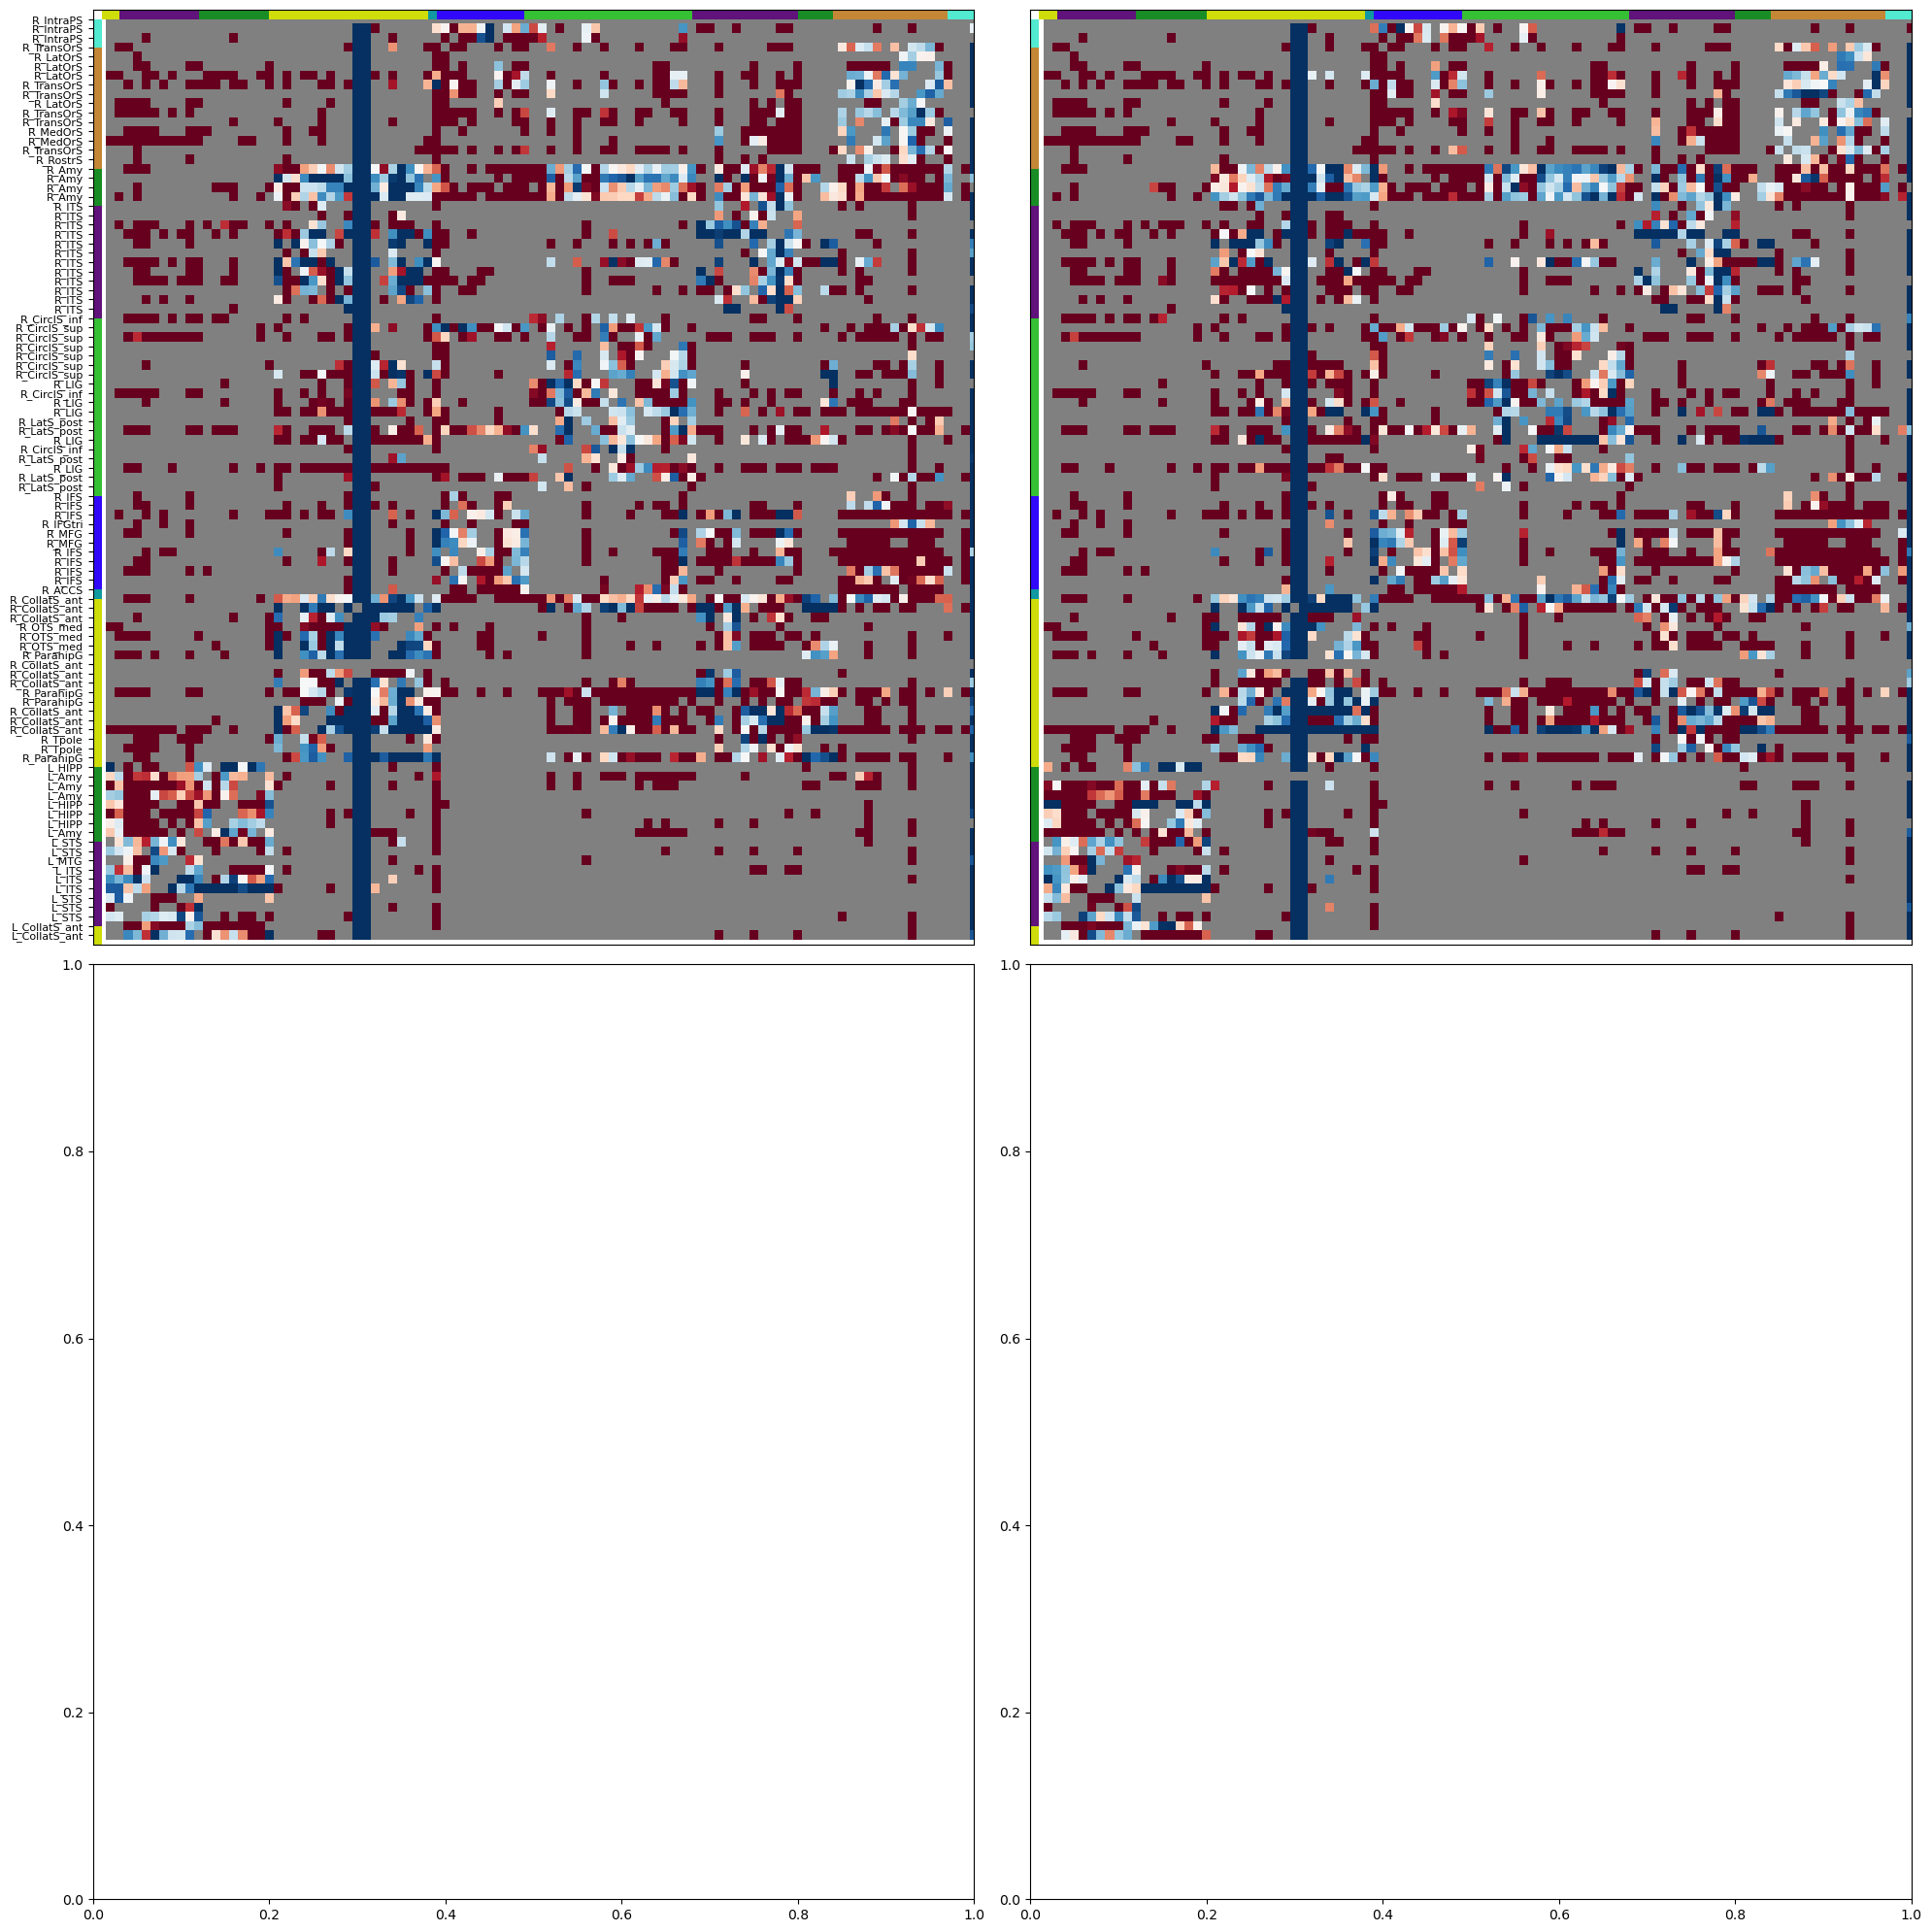

In [474]:
conditions = ['S_A', 'S_V','C_A', 'C_V']
fig, axs = plt.subplots(2, 2, figsize=(20,20))

for row_ix, start in enumerate(['S', 'C']):
    for col_ix, end in enumerate(['A', 'V']):
        ax = axs[row_ix, col_ix]

        cond = start+'_'+end
        df = con_mean_CT[(con_mean_CT.CT == cond)]
        df = df.reset_index(drop=True)
        df.Stim = df.Stim.astype('int')
        df.Chan = df.Chan.astype('int')
        if len(df)>0:
            matrix = np.full((np.max([df.Chan.max(), df.Stim.max()]) + 1, np.max([df.Chan.max(), df.Stim.max()]) + 1), np.nan)  # Initialize with NaN

            # Fill the matrix with LL_norm values
            for index, row in df.iterrows():
                matrix[row["Stim"], row["Chan"]] = row["LL_norm"]

            plot_BM(matrix, labels_all, hemisphere, ax, axcolor=None, cmap=cmap, vlim=[0.7, 1.3], sort=1)
            # remove x-ticks and y-ticks if not 
            if row_ix+col_ix>0:
                ax.set_yticks([])
            else:
                ax.set_xticks([])
            if col_ix == 1:
                ax.set_xticks([])
plt.tight_layout()
plt.show()


In [ ]:
condition = 'S_V'
df = con_mean_CT[(con_mean_CT.Sig>0.5)&(con_mean_CT.CT==condition)]
df = df.reset_index(drop=True)
df.Stim = df.Stim.astype('int')
df.Chan = df.Chan.astype('int')
matrix = np.full((np.max([df.Chan, df.Stim])+1,np.max([df.Chan, df.Stim])+1), np.nan)  # Initialize with NaN

# Fill the matrix with LL_norm values
for index, row in df.iterrows():
    matrix[row["Stim"], row["Chan"]] = row["LL_norm"]

fig      = plt.figure(figsize=(7,7))
axmatrix = fig.add_axes([0.15,0.15,0.7,0.7])
plot_BM(matrix, labels_all, hemisphere, axmatrix, axcolor=None, cmap=cmap, vlim=[0.8, 1.2], sort=1)

In [426]:
con_increase = con_mean_CT[con_mean_CT.LL_norm>1.2]
con_increase = con_increase.reset_index(drop=True)

In [427]:
con_decrease = con_mean_CT[con_mean_CT.LL_norm<0.8]
con_decrease = con_increase.reset_index(drop=True)

In [241]:
k = -1

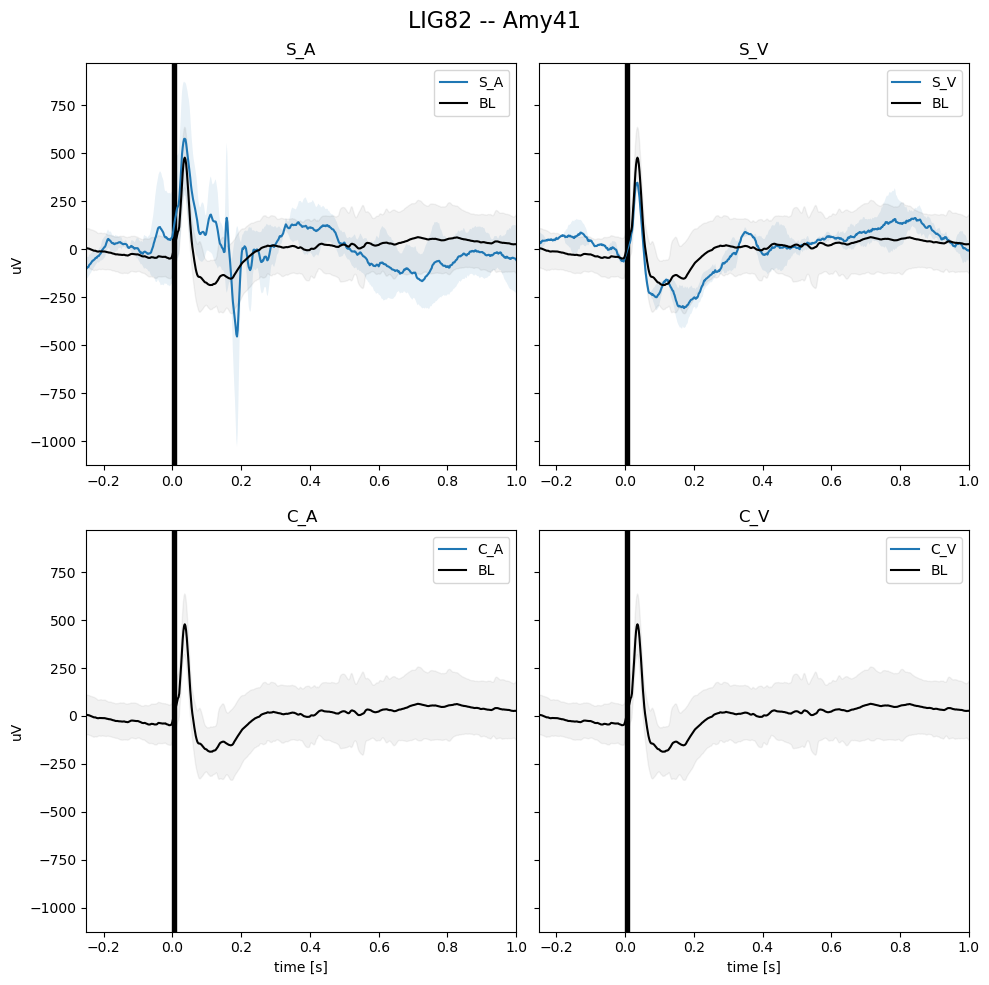

In [267]:
k = np.random.choice(np.arange(len(con_increase)))
sc = con_increase.Stim.values[k].astype('int')
rc = con_increase.Chan.values[k].astype('int')

plot_conditions(con_trial_CT, EEG_resp, sc, rc,labels_all)

In [24]:
con_trial_CT['Con_ID'] = con_trial_CT.groupby(['Stim', 'Chan']).ngroup()

In [ ]:
for idd in np.unique(con_trial_CT['Con_ID']):

In [37]:
conID = 0
con_trial_CT[(con_trial_CT.Con_ID == conID)]
cond = ['S_A', 'S_V']
trials = np.zeros((6, 2000))
for ix, con_sel in enumerate(cond):
    trial_num = con_trial_CT.loc[(con_trial_CT.CT == con_sel)&(con_trial_CT.Con_ID == conID), 'Num'].values.astype('int')
    rc = con_trial_CT.loc[(con_trial_CT.CT == con_sel)&(con_trial_CT.Con_ID == conID), 'Chan'].values.astype('int')[0]
    trials[ix*3:(ix+1)*3,:] = EEG_resp[rc, trial_num, :]*(-1)**ix

In [75]:
condID_in = np.unique(con_mean_CT.loc[con_mean_CT.LL_norm>1.2, 'Con_ID'])

In [76]:
k = -1

(-0.5, 1.0)

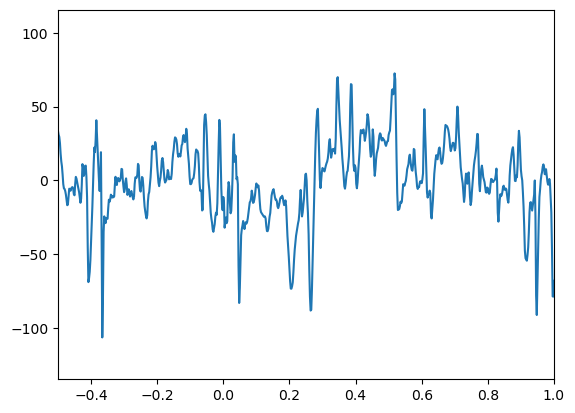

In [174]:
k = k+1
conID = condID_in[k]
trials = np.zeros((6, 2000))
for ix, con_sel in enumerate(cond):
    trial_num = con_trial_CT.loc[(con_trial_CT.CT == con_sel)&(con_trial_CT.Con_ID == conID), 'Num'].values.astype('int')
    rc = con_trial_CT.loc[(con_trial_CT.CT == con_sel)&(con_trial_CT.Con_ID == conID), 'Chan'].values.astype('int')[0]
    trials[ix*3:(ix+1)*3,:] = EEG_resp[rc, trial_num, :]*(-1)**ix
    
plt.plot(x_ax, np.mean(trials,0))
plt.xlim([-0.5, 1])

In [183]:
import itertools

## Signifance testing

In [287]:
CT_sig = get_conditions_surr(con_trial_CT, labels_all, n_surr=100, n_trials=3)

In [288]:
CT_sig.insert(0, 'Subj', subj)
CT_sig.insert(4, 'DI', CT_sig.Sig)
CT_sig.Sig = 1

In [289]:
import re
from scipy.spatial.distance import cdist

In [290]:
# Create new columns 'StimA' and 'ChanA' using vectorized operations
CT_sig['StimA'] = [re.sub(r'\d', '', label) for label in labels_all[CT_sig['Stim']]]
CT_sig['ChanA'] = [re.sub(r'\d', '', label) for label in labels_all[CT_sig['Chan']]]


In [291]:
# Get the indices of 'Stim' and 'Chan' channels
stim_indices = CT_sig['Stim'].values
chan_indices = CT_sig['Chan'].values

# Get the corresponding coordinates for 'Stim' and 'Chan' channels
stim_coords = coord_all[stim_indices]
chan_coords = coord_all[chan_indices]

# Calculate Euclidean distances using cdist
distances = cdist(stim_coords, chan_coords, metric='euclidean')

# Add 'd' column to CT_sig DataFrame
CT_sig['d'] = distances[0]

In [102]:
for cond in np.unique(CT_sig.CT):
    df_save = CT_sig[CT_sig.CT == cond]
    df_save = df_save.reset_index(drop=True)
    df_save.to_csv(os.path.join(path_patient_analysis,'BrainMapping', 'CT', 'data', cond+'.csv'), header = True, index =False)

In [292]:
CT_sig_in = CT_sig[CT_sig.DI==1]
CT_sig_in = CT_sig_in.reset_index(drop=True)
k = -1

In [293]:
CT_sig_de = CT_sig[CT_sig.DI==-1]
CT_sig_de = CT_sig_de.reset_index(drop=True)
k = -1

In [ ]:
plot_conditions_surr(con_trial_CT, sc, rc, labels_all, n_surr=100, n_trials=3)
plot_conditions(con_trial_CT, EEG_resp, sc, rc,labels_all)

C:\Users\i0328442\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\i0328442\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


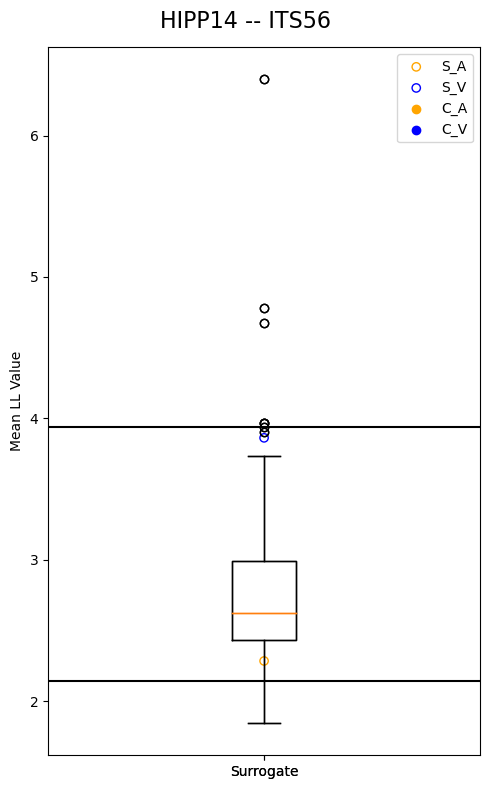

C:\Users\i0328442\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\i0328442\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\i0328442\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\i0328442\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\i0328442\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


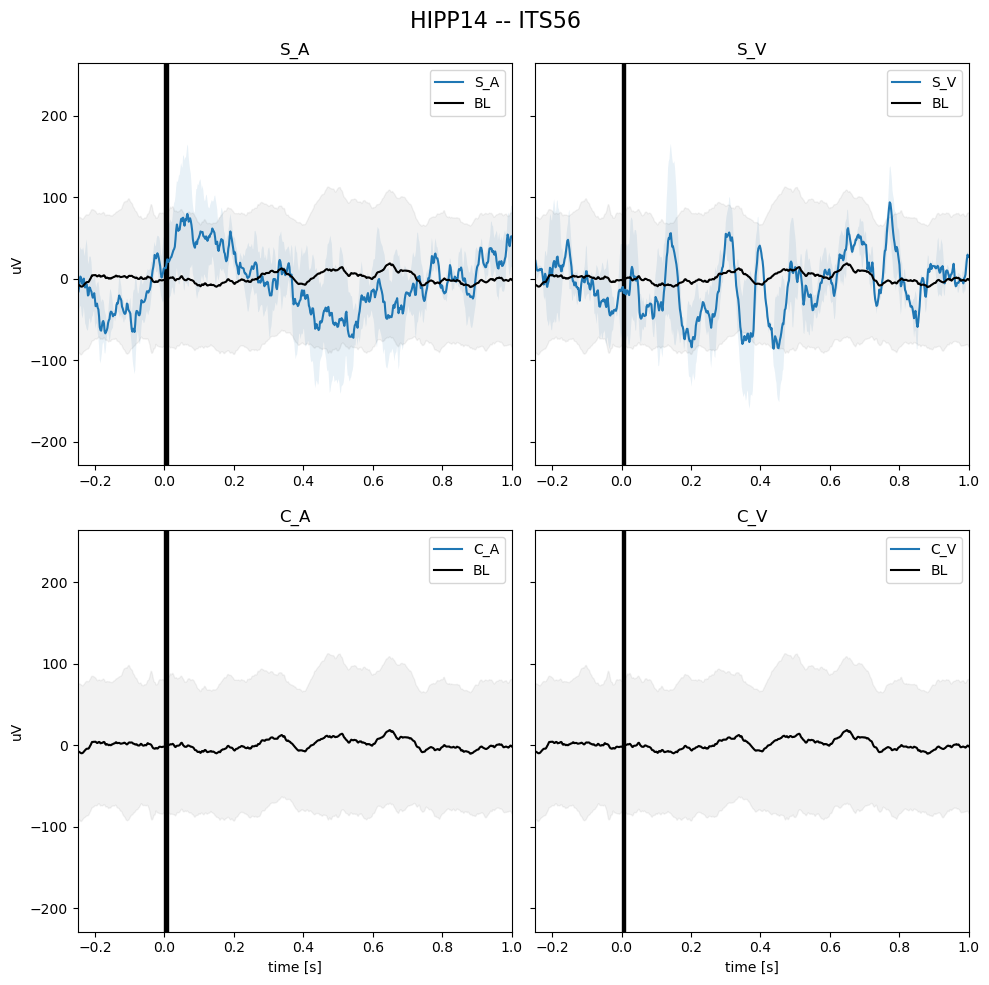

In [317]:
k = k+1
sc = CT_sig_in.Stim.values[k].astype('int')
rc = CT_sig_in.Chan.values[k].astype('int')

plot_conditions_surr(con_trial_CT, sc, rc, labels_all, n_surr=100, n_trials=3)
plot_conditions(con_trial_CT, EEG_resp, sc, rc,labels_all)

In [286]:
def get_conditions_surr(con_trial_CT, labels_all, n_surr=100, n_trials=3):
    conditions = ['S_A', 'S_V'] # ['S_A', 'S_V', 'C_A', 'C_V']
    
    con_CT_sig = []

    for sc, rc in itertools.product(range(len(labels_all)), repeat=2):
        data_plot = con_trial_CT[(con_trial_CT.Sig > -1) & (con_trial_CT.Artefact == 0) & (con_trial_CT.Stim == sc) & (con_trial_CT.Chan == rc)]
        if not data_plot.empty:
            if np.mean(data_plot.Sig)>0:
                LL_BL = data_plot[data_plot.CT == "BL"]["LL"].values
                if len(LL_BL)>10:
                    data_surr = [np.mean(np.random.choice(LL_BL, size=n_trials, replace=True)) for _ in range(n_surr)]
                    thr_u, thr_l = np.percentile(data_surr, [95, 5])

                    for cond in conditions:
                        LL_con = data_plot[data_plot.CT == cond]["LL"].mean()
                        sig = int(LL_con > thr_u) - int(LL_con < thr_l)

                        con_CT_sig.append({
                            "Stim": sc,
                            "Chan": rc,
                            "CT": cond,
                            "LL": LL_con,
                            "Sig": sig
                        })

    return pd.DataFrame(con_CT_sig)


In [180]:
def get_conditions_surr(con_trial_CT, sc, rc, labels_all, n_surr=100, n_trials=3):
    # Define conditions
    conditions = ['S_A', 'S_V', 'C_A', 'C_V']
    for sc in range(len(labels_all)):
        for rc in range(len(labels_all)):
            data_plot = con_trial_CT.loc[(con_trial_CT.Artefact == 0) & (con_trial_CT.Stim == sc) & (con_trial_CT.Chan == rc)]
            if len(data_plot)>0:
                LL_BL = data_plot.loc[data_plot.CT == "BL", "LL"].values
                data_surr = np.zeros((n_surr,))

                for i in range(n_surr):
                    random_indices = np.random.choice(len(LL_BL), size=n_trials, replace=False)
                    data_surr[i] = np.mean(LL_BL[random_indices])
                    
                thr_u = np.percentile(data_surr,95)
                thr_l = np.percentile(data_surr,5)
    
                for idx, cond in enumerate(conditions):
                    LL_con = np.mean(data_plot.loc[data_plot.CT == cond, "LL"].values)
                    sig = 0
                    if LL_con> thr_up: sig = 1
                    if LL_con< thr_l: sig = -1  
                    # append as new row with: Stim = sc, Chan = rc, Ct = cond, LL = LL_con, Sig = sig
        # create pandas table : con_CT_sig
    return con_CT_sig

In [179]:
def plot_conditions_surr(con_trial_CT, sc, rc, labels_all, n_surr=100, n_trials=3):
    # Define conditions
    conditions = ['S_A', 'S_V', 'C_A', 'C_V']
    data_plot = con_trial_CT.loc[(con_trial_CT.Artefact == 0) & (con_trial_CT.Stim == sc) & (con_trial_CT.Chan == rc)]
    LL_BL = data_plot.loc[data_plot.CT == "BL", "LL"].values
    data_surr = np.zeros((n_surr,))
    
    for i in range(n_surr):
        random_indices = np.random.choice(len(LL_BL), size=n_trials, replace=False)
        data_surr[i] = np.mean(LL_BL[random_indices])
    
    fig = plt.figure(figsize=(5, 8))
    fig.patch.set_facecolor('xkcd:white')
    plt.suptitle(f'{labels_all[sc]} -- {labels_all[rc]}', fontsize=16)
    
    plt.boxplot(data_surr, vert=True, labels=['Surrogate'])
    
    for idx, cond in enumerate(conditions):
        LL_con = np.mean(data_plot.loc[data_plot.CT == cond, "LL"].values)
        # Determine marker type based on condition
        marker = 'o' if cond.startswith('S') else 'o'
        # Determine marker color based on condition
        marker_color = 'blue' if cond.endswith('V') else 'orange'
        
        face_color = 'none' if cond.startswith('S') else marker_color
        
        plt.scatter(1, LL_con, marker='o', facecolors=face_color, edgecolors=marker_color, label=cond)
    
    # plt.yticks(range(1, len(conditions) + 1), conditions)
    plt.ylabel('Mean LL Value')
    plt.boxplot(data_surr, vert=True, labels=['Surrogate'])
    plt.axhline(np.percentile(data_surr,5), color='k')
    plt.axhline(np.percentile(data_surr,95), color='k')
    plt.legend()
    plt.tight_layout()
    plt.show()


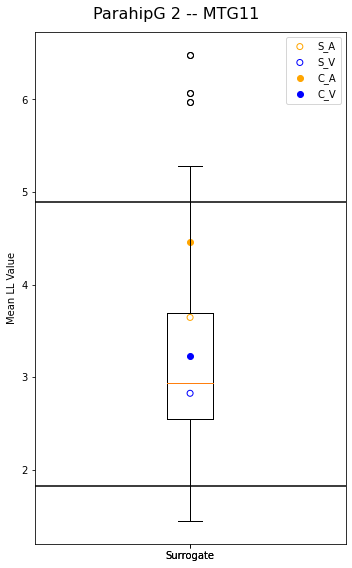

In [307]:
plot_conditions_surr(con_trial_CT, 1, 10, labels_all, n_surr=100, n_trials=3)

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


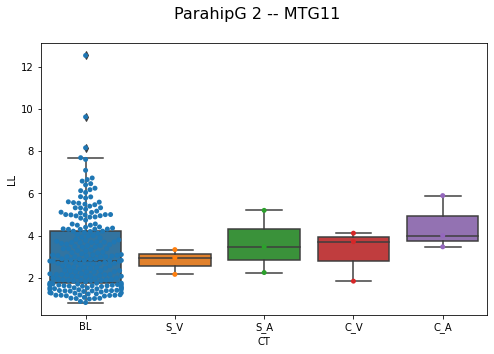

In [273]:
plot_conditions_box(con_trial_CT, 1, 10, labels_all)

In [178]:
def plot_conditions_box(con_trial_CT, sc, rc, labels_all):
    # Define conditions
    conditions = ['S_A', 'S_V', 'C_A', 'C_V']
    data_plot = con_trial_CT.loc[(con_trial_CT.Artefact == 0) &(con_trial_CT.Stim == sc) & (con_trial_CT.Chan == rc)]
    fig = plt.figure(figsize=(8,5))
    fig.patch.set_facecolor('xkcd:white')
    sns.boxplot(x='CT', y='LL', data= data_plot)
    sns.swarmplot(x='CT', y='LL', data= data_plot)
    plt.suptitle(f'{labels_all[sc]} -- {labels_all[rc]}', fontsize=16)
    plt.show()
    

In [543]:
def plot_conditions(con_trial_CT, EEG_resp, sc, rc, labels_all):
    # Define conditions
    conditions = ['S_A', 'S_V', 'C_A', 'C_V']
    # Plot BL signal (assumed to be in the first condition)
    num_bl = con_trial_CT.loc[(con_trial_CT.Artefact == 0) &(con_trial_CT.Stim == sc) & (con_trial_CT.Chan == rc) & (con_trial_CT.CT == "BL"), 'Num'].values.astype('int')
    mn_bl = np.mean(EEG_resp[rc, num_bl, :], axis=0)
    st_bl = np.std(EEG_resp[rc, num_bl, :], axis=0)

    # Create subplots with shared y-axis
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
    fig.patch.set_facecolor('xkcd:white')
    plt.suptitle(f'{labels_all[sc]} -- {labels_all[rc]}', fontsize=16)

    for row, start in enumerate(['S', 'C']):
        for col, end in enumerate(['A', 'V']):
            ax = axs[row, col]
            
            for cond in conditions:
                if cond.startswith(start) and cond.endswith(end):
                    num = con_trial_CT.loc[(con_trial_CT.Stim == sc) & (con_trial_CT.Chan == rc) & (con_trial_CT.CT == cond), 'Num'].values.astype('int')
                    mn = np.mean(EEG_resp[rc, num, :], axis=0)
                    st = np.std(EEG_resp[rc, num, :], axis=0)
                    ax.plot(x_ax, mn, label=cond)
                    ax.fill_between(x_ax, mn - st, mn + st, alpha=0.1)
                    ax.set_title(cond)
            
            ax.plot(x_ax, mn_bl, color='black', label='BL')
            ax.fill_between(x_ax, mn_bl - st_bl, mn_bl + st_bl, color='black', alpha=0.05)
            ax.set_xlim([-0.25, 1])
            ax.axvspan(0, 0.01, color=[0, 0, 0])
            ax.legend()
            
            if col == 0:  # Show y-axis label for first column
                ax.set_ylabel('uV')
            if row == 1:  # Show x-axis label for last row
                ax.set_xlabel('time [s]')

    plt.tight_layout(h_pad=1.5, w_pad=0.5)  # Add more spacing between subplots
    # plt.show()

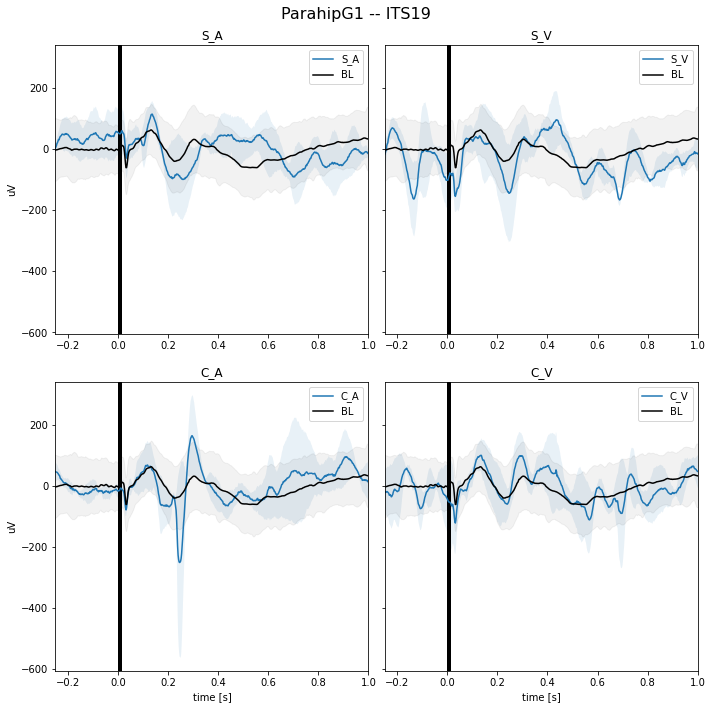

In [146]:
k = k+1
sc = con_decrease.Stim.values[k].astype('int')
rc = con_decrease.Chan.values[k].astype('int')

plot_conditions(con_trial_CT, EEG_resp, sc, rc,labels_all)

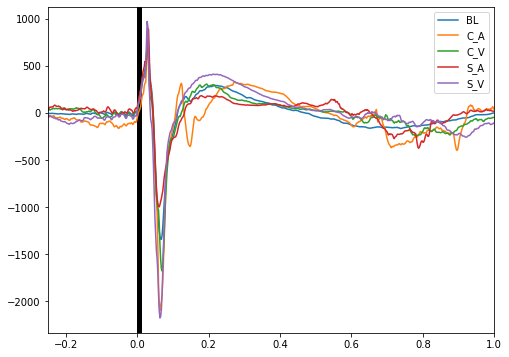

In [47]:
plt.figure(figsize=(8,6))
for cond in np.unique(con_trial_CT.CT):
    num = con_trial_CT.loc[(con_trial_CT.Stim==sc)&(con_trial_CT.Chan==rc)&(con_trial_CT.CT==cond), 'Num'].values.astype('int')
    mn = np.mean(EEG_resp[rc, num,:], 0)
    plt.plot(x_ax, mn, label = cond)
plt.xlim([-0.25, 1])
plt.axvspan(0,0.01, color=[0,0,0])
plt.legend()